In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
tf.enable_eager_execution()

In [3]:
height, width = 100, 100
box_height, box_width = 10, 10

In [4]:
def draw_box(x,y, h=box_height, w=box_width, height=height, width=width):
    '''Moving square that is visual input'''
    rad = int(box_height / 2)
    canvas = np.zeros((height, width))
    inds_x, inds_y = np.meshgrid(np.mod(np.arange(x-rad, x+rad, 1), height),
                               np.mod(np.arange(y-rad, y+rad, 1), width))
    canvas[inds_x, inds_y] = 1
    return canvas

### First trajectory

In [5]:
x_ = np.arange(0, 2000, 1)
x = np.int32(5*np.sin(0.1*x_))
y = 40

In [40]:
train_batch = tf.convert_to_tensor(
    np.stack([draw_box(k, y) for k in x]).reshape(
        2000, height, width, 1), dtype=tf.float32)

In [123]:
batch_size = 10
train_buff = 2000
train_dataset = tf.data.Dataset.from_tensor_slices(train_batch).batch(batch_size)

In [124]:
train_dataset

<DatasetV1Adapter shapes: (?, 100, 100, 1), types: tf.float32>

In [115]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                layers.InputLayer(input_shape=(100, 100, 1)),
                layers.Conv2D(
                filters=32, kernel_size=3, strides=(2,2), activation='relu'),
                layers.Conv2D(
                filters=64, kernel_size=3, strides=(2,2), activation='relu'),
                layers.Flatten(),
                layers.Dense(latent_dim + latent_dim)
            ]
        )
        
        self.decoder = tf.keras.Sequential(
            [
                layers.InputLayer(input_shape=(latent_dim,)),
                layers.Dense(units=7*7*32, activation=tf.nn.relu),
                layers.Reshape(target_shape=(7,7,32)),
                layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=(5,5),
                padding='SAME', activation='relu'),
                layers.Conv2DTranspose(filters=32,kernel_size=3,
                        strides=(3,3), padding='SAME', activation='relu'),
                layers.Conv2DTranspose(
                filters=1,kernel_size=5, strides=(1,1), padding='SAME')
            ]
        )
        
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        # splits the encoder output in half
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2,
                               axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs

        return logits

In [116]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

def compute_gradients(model, x):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  return tape.gradient(loss, model.trainable_variables), loss

def apply_gradients(optimizer, gradients, variables):
  optimizer.apply_gradients(zip(gradients, variables))

In [125]:
epochs = 5
latent_dim = 5
num_examples = 10

gen_vector = tf.random.normal(shape=[num_examples, latent_dim])
model = CVAE(latent_dim)

In [126]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model.sample(test_input)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

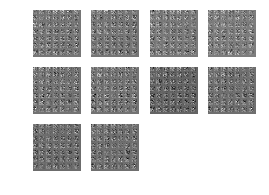

In [127]:
generate_and_save_images(model, 0, gen_vector)

In [128]:
compute_gradients(model, train_x)

ResourceExhaustedError: OOM when allocating tensor with shape[200,105,105,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2DBackpropInput] name: sequential_1/conv2d_transpose_1/conv2d_transpose_1/conv2d_transpose/

In [ ]:
### import time
for epoch in range(1, epochs+1):
    start_time = time.time()
    for train_x in train_dataset:
        gradients, loss = compute_gradients(model, train_x)
        apply_gradients(optimizer, gradients, model.trainable_variables)
    end_time = time.time()
    
    if epoch % 1 == 0:
        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            loss(compute_loss(model, test_x))
        elbo = -loss.result()
        display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
        generate_and_save_images(model, epoch, random_vector_for_generation)

In [54]:
layers.Conv2DTranspose?

In [121]:
tf.reset_default_graph()